In [1]:
import numpy as np
import os

from keras.src.utils.module_utils import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D,BatchNormalization, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D

from matplotlib.image import imread
import matplotlib.pyplot as plt
import random

In [2]:
# File Directory for both the train and test
train_path = "C:\\Users\\yaren\\PycharmProjects\\ResNet50-ChestCancer-Detection\\Data\\train"
val_path = "C:\\Users\\yaren\\PycharmProjects\\ResNet50-ChestCancer-Detection\\Data\\valid"
test_path = "C:\\Users\\yaren\\PycharmProjects\\ResNet50-ChestCancer-Detection\\Data\\test"

In [3]:
INPUT_SHAPE = (299, 299, 3)
NUM_CLASSES = 4

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range= 0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   preprocessing_function=preprocess_input,
                                   dtype="float32")


test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 dtype="float32")

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 dtype="float32")

In [4]:
train_data = train_datagen.flow_from_directory(train_path,
                                                 target_size=(299, 299),
                                                 batch_size=32,
                                                 class_mode="categorical")
test_data = test_datagen.flow_from_directory(test_path,
                                            target_size=(299, 299),
                                            batch_size=32,
                                            class_mode="categorical")
val_data = val_datagen.flow_from_directory(val_path,
                                          target_size=(299, 299),
                                          batch_size=32,
                                          class_mode="categorical")

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [5]:
from inceptionv3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Base model: InceptionV3 (ImageNet ağırlıklı)
base_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3)  # 🔥 InceptionV3 için doğru giriş boyutu
)

# 🔒 Katmanları dondur (son birkaç katman hariç)
for layer in base_model.layers[:-30]:  # sadece son 30 katmanı aç
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# 🔧 Yeni sınıflandırıcı katmanlar
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # opsiyonel ek katman
x = Dense(4, activation='softmax')(x)  # 4 sınıf için çıktı

# 🔄 Modeli oluştur
model = Model(inputs=base_model.input, outputs=x)

# ⚙️ Derle
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [15]:
checkpoint = ModelCheckpoint("best_inception_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=0.5, verbose=1)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=2
)

C:\Users\yaren\PycharmProjects\ResNet50-ChestCancer-Detection\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.58333, saving model to best_inception_model.keras
20/20 - 54s - 3s/step - accuracy: 0.5334 - loss: 1.0298 - val_accuracy: 0.5833 - val_loss: 0.9382 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_accuracy improved from 0.58333 to 0.62500, saving model to best_inception_model.keras
20/20 - 79s - 4s/step - accuracy: 0.7162 - loss: 0.7022 - val_accuracy: 0.6250 - val_loss: 0.7988 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_accuracy improved from 0.62500 to 0.68056, saving model to best_inception_model.keras
20/20 - 51s - 3s/step - accuracy: 0.7537 - loss: 0.5826 - val_accuracy: 0.6806 - val_loss: 0.7101 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_accuracy improved from 0.68056 to 0.69444, saving model to best_inception_model.keras
20/20 - 51s - 3s/step - accuracy: 0.8320 - loss: 0.4813 - val_accuracy: 0.6944 - val_loss: 0.7477 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: val_accuracy did not improve from 

In [16]:
from tensorflow.keras.models import load_model
saved_model = load_model("best_inception_model.keras")
score = saved_model.evaluate(test_data, verbose=1)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8599 - loss: 0.4460
Test loss: 0.3993781507015228
Test accuracy: 0.8730158805847168


In [17]:
val_loss, val_acc = saved_model.evaluate(val_data, verbose=1)
print("\n📊 VALIDATION SET:")
print(f"✅ Accuracy: {val_acc:.4f}")
print(f"❌ Loss:     {val_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 781ms/step - accuracy: 0.9518 - loss: 0.5122

📊 VALIDATION SET:
✅ Accuracy: 0.9583
❌ Loss:     0.4312


In [18]:
train_loss, train_acc = saved_model.evaluate(train_data, verbose=1)
print("\n📊 TRAIN SET:")
print(f"✅ Accuracy: {train_acc:.4f}")
print(f"❌ Loss:     {train_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9970 - loss: 0.0235

📊 TRAIN SET:
✅ Accuracy: 0.9935
❌ Loss:     0.0317


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


<Figure size 800x600 with 0 Axes>

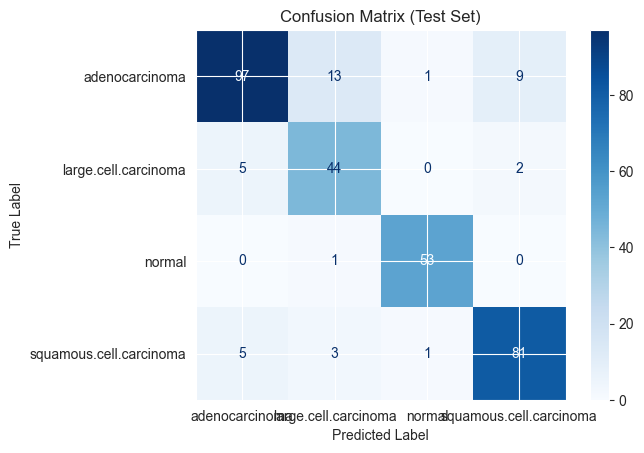


📄 Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.91      0.81      0.85       120
   large.cell.carcinoma       0.72      0.86      0.79        51
                 normal       0.96      0.98      0.97        54
squamous.cell.carcinoma       0.88      0.90      0.89        90

               accuracy                           0.87       315
              macro avg       0.87      0.89      0.88       315
           weighted avg       0.88      0.87      0.87       315



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 🔄 Sınıf adlarını al
class_names = list(test_data.class_indices.keys())

# 🔍 Gerçek etiketleri ve tahminleri topla
y_true = []
y_pred = []

# ⚠️ test_data.shuffle = False olmalı doğru sıralama için
test_data.reset()  # Sıfırlanmazsa karışık olabilir

for i in range(len(test_data)):
    x_batch, y_batch = test_data[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    preds = saved_model.predict(x_batch)
    y_pred.extend(np.argmax(preds, axis=1))

    # 🛑 Son batch incomplete olabilir
    if (i + 1) * test_data.batch_size >= test_data.samples:
        break

# 🧮 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# 🎨 Görselleştir
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 🧾 Ekstra: classification report
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
